# Learn about collaborative filtering and weighted alternating least square with tensorflow

In [ ]:
# What you learn

# 1. collaborative filtering
# 2. Weighted alternating least squares (WALS) method
# 3. tensorflow (v1.15.0)

In [ ]:
# The data contains movie rating from 943 users for 1682 movies and the ratings 
# range 1,2,...,5, with average rating of 3.5298. If you predicts all the testing 
# ratings with this average rating value, the root mean squared error (RMSE) on 
# testing data is 1.13. If we use the WALS method with various weighting schemes, 
# after hyperparameter tunings, the optimized RMSE on testing data are:

In [ ]:
# weight type    RMSE on training set     RMSE on test set
# baseline        1.12                      1.13
# uniform         2.35                      2.51
# linear          0.91                      1.01
# log             0.87                      0.95

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import tensorflow as tf
import numpy as np
from scipy.sparse import coo_matrix
from tensorflow.contrib.factorization.python.ops import factorization_ops

print(tf.__version__)

1.15.0


In [4]:
from platform import python_version

print(python_version())

3.6.13


In [ ]:
# Data contains 100k ratings from 943 users. In total, there are 1682 items. You see 
# 93% (1 - 100k/(1682*943)) of the (item, user) pairs are empty (i.e., not rated).
# The goal of the recommendation system problem here is to fill these empty cells.

In [5]:
input_file = 'u.data.csv'
headers = ['user_id', 'item_id', 'rating', 'timestamp']
header_row = None
ratings_df = pd.read_csv(input_file,
                         sep='\t',
                         names=headers,
                         header=header_row,
                         dtype={
                           'user_id': np.int32,
                           'item_id': np.int32,
                           'rating': np.float32,
                           'timestamp': np.int32,
                         })


def n_unique(colnm):
    n = len(np.unique(ratings_df[colnm]))
    return(n)
n_users = n_unique("user_id")    
n_items = n_unique("item_id")   
print("Total number of users:",n_users)
print("Total number of items:",n_items)

print("ratings_df.shape =",ratings_df.shape)
ratings_df.head()

Total number of users: 943
Total number of items: 1682
ratings_df.shape = (100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
# The number of ratings per users and the number of ratings per items both have 
# highly skewed distribution. Most of the users rate movies less than 100 times. 
# Most of the items have less than 100 ratings. You will see later that the 
# weights on the WALS algorithm essentiallily controls this skewed distribution 
# by weighting each item (or user) differently, based on the frequency of the 
# rating per item (per user).

In [6]:
ratings_df.isnull().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

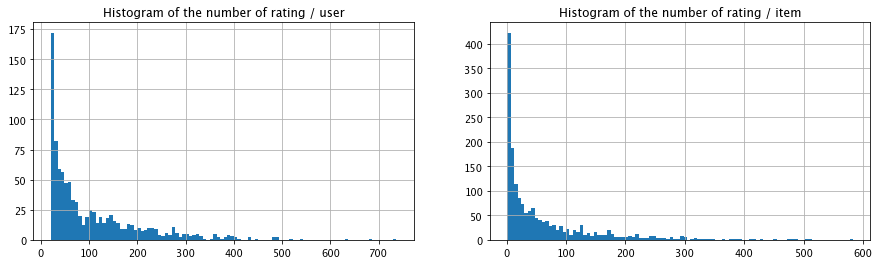

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,4))
ratings_df.groupby("user_id").count()["item_id"].hist(bins=100,ax=ax[0])
_ = ax[0].set_title("Histogram of the number of rating / user")

ratings_df.groupby("item_id").count()["user_id"].hist(bins=100,ax=ax[1])
_ = ax[1].set_title("Histogram of the number of rating / item")

In [10]:
 ratings_df.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [ ]:
# Normalize user_id and item_id so that the indexing starts at 0

In [11]:
ratings = ratings_df[['user_id', 'item_id', 'rating']].values
ratings[:,0] -= 1
ratings[:,1] -= 1
print(ratings.shape,ratings.dtype)
for i in [0,1]:
    print("start indexing at:",np.min(ratings[:,i]),"end indexint at:",np.max(ratings[:,i]))

(100000, 3) float64
start indexing at: 0.0 end indexint at: 942.0
start indexing at: 0.0 end indexint at: 1681.0


In [12]:
print(ratings.shape,ratings.dtype)

(100000, 3) float64


In [ ]:
# Split between training and testing data

In [13]:
def _create_sparse_train_and_test(ratings, n_users, n_items):
    """Given ratings, create sparse matrices for train and test sets.
    Args:
      ratings:  list of ratings tuples  (u, i, r)
      n_users:  number of users
      n_items:  number of items
    Returns:
       train, test sparse matrices in scipy coo_matrix format.
       
    original extracted from: 
    https://github.com/GoogleCloudPlatform/tensorflow-recommendation-wals/blob/master/wals_ml_engine/trainer/model.py#L218
    """
    print(ratings.shape,ratings.min(),n_users,n_items)
    # pick a random test set of entries, sorted ascending
    test_set_size = int(len(ratings) * TEST_SET_RATIO)
    np.random.seed(1)
    test_set_idx = np.random.choice(range(len(ratings)),
                                    size=test_set_size, replace=False)
    test_set_idx = sorted(test_set_idx)

    # sift ratings into train and test sets
    ts_ratings = ratings[test_set_idx]
    tr_ratings = np.delete(ratings, test_set_idx, axis=0)
    
    # create training and test matrices as coo_matrix's
    u_tr, i_tr, r_tr = zip(*tr_ratings)
    tr_sparse = coo_matrix((r_tr, (u_tr, i_tr)), shape=(n_users, n_items))

    u_ts, i_ts, r_ts = zip(*ts_ratings)
    test_sparse = coo_matrix((r_ts, (u_ts, i_ts)), shape=(n_users, n_items))

    return tr_sparse, test_sparse

## 10% of the data will be test set.
TEST_SET_RATIO = 0.1
tr_sparse, test_sparse = _create_sparse_train_and_test(ratings, n_users, n_items)

print("sparse matrix dimension:",tr_sparse.shape,tr_sparse.row.shape,tr_sparse.col.shape,tr_sparse.data.min())
print("sparse matrix dimension:",test_sparse.shape,test_sparse.row.shape,test_sparse.col.shape)

(100000, 3) 0.0 943 1682
sparse matrix dimension: (943, 1682) (90000,) (90000,) 1.0
sparse matrix dimension: (943, 1682) (10000,) (10000,)


In [14]:
def make_wts(data, wt_type, obs_wt, feature_wt_exp, axis):
    """Generate observed item weights.
      Args:
        data:             coo_matrix of ratings data
        wt_type:          weight type, LOG_RATINGS or LINEAR_RATINGS
        obs_wt:           linear weight factor
        feature_wt_exp:   logarithmic weight factor
        axis:             axis to make weights for, 1=rows/users, 0=cols/items
      Returns:
        vector of weights for cols (items) or rows (users)
    """
    assert wt_type in ["LOG_RATINGS","LINEAR_RATINGS"]
    # recipricol of sum of number of items across rows (if axis is 0)
    frac = np.array(1.0/(data > 0.0).sum(axis))
    
    # filter any invalid entries
    frac[np.ma.masked_invalid(frac).mask] = 0.0
    
    # normalize weights according to assumed distribution of ratings
    if wt_type == "LOG_RATINGS":
        wts = np.array(np.power(frac, feature_wt_exp)).flatten()
    elif wt_type == "LINEAR_RATINGS":
        wts = np.array(obs_wt * frac).flatten()
    
    # check again for any numerically unstable entries
    assert np.isfinite(wts).sum() == wts.shape[0]
    return wts

(1682,)


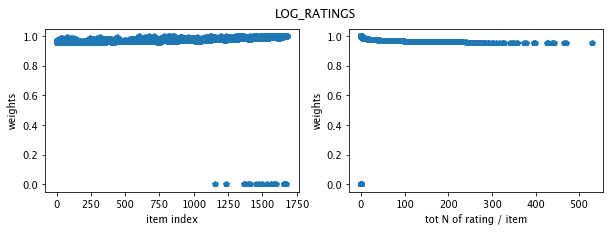

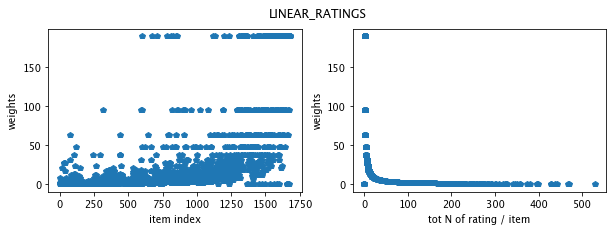

In [15]:
n_nonzero_items = np.array((tr_sparse > 0).sum(axis=0)).squeeze()
print(n_nonzero_items.shape)


def plot(col_wt,n_nonzero_items,title):
    fig, ax = plt.subplots(1,2,figsize=(10,3))
    ax[0].plot(col_wt,"p")
    ax[0].set_xlabel("item index")
    ax[0].set_ylabel("weights")
    ax[1].plot(n_nonzero_items,col_wt,"p")
    ax[1].set_xlabel("tot N of rating / item")
    ax[1].set_ylabel("weights")
    plt.suptitle(title)
    plt.show()
    
for wt_type in ["LOG_RATINGS","LINEAR_RATINGS"]:    
    col_wt = make_wts(tr_sparse, wt_type, obs_wt=189.8, feature_wt_exp=0.008, axis=0)
    plot(col_wt,n_nonzero_items,title=wt_type)

In [16]:
def define_graph(data,PARAMS):
    graph = tf.Graph()
    with graph.as_default():

        input_tensor = tf.SparseTensor(indices=np.array([data.row, data.col]).T,
                                       values=(data.data).astype(np.float32),
                                       dense_shape=data.shape)


        row_wts = None
        col_wts = None
        num_rows = data.shape[0]
        num_cols = data.shape[1]

        # initialize the weights 
        if PARAMS["wt_type"] in ["LOG_RATINGS","LINEAR_RATINGS"]:
            row_wts = np.ones(num_rows)
            col_wts = make_wts(data, 
                               PARAMS["wt_type"], 
                               PARAMS['feature_wt_factor'],
                               PARAMS['feature_wt_exp'],axis=0)

        model = factorization_ops.WALSModel(num_rows, num_cols, PARAMS["latent_factors"],
                                            unobserved_weight=PARAMS["unobs_weight"],
                                            regularization=PARAMS["regularization"],
                                            row_weights=row_wts,
                                            col_weights=col_wts)

        return(graph,model,input_tensor)

In [17]:
def train(graph,model,input_tensor,verbose=False):
    sess = tf.Session(graph=graph)
    with graph.as_default():
        row_update_op = model.update_row_factors(sp_input=input_tensor)[1]
        col_update_op = model.update_col_factors(sp_input=input_tensor)[1]

        sess.run(model.initialize_op)
        sess.run(model.worker_init)
        for i in range(num_iterations):
            sess.run(model.row_update_prep_gramian_op)
            sess.run(model.initialize_row_update_op)
            sess.run(row_update_op)
            sess.run(model.col_update_prep_gramian_op)
            sess.run(model.initialize_col_update_op)
            sess.run(col_update_op)
            if verbose and i % 1 == 0:
                rf = sess.run(row_factor)
                print("iter",i,rf.mean(),rf.min(),sess.run(col_factor).mean())
    return sess 

import math
def get_rmse(output_row, output_col, actual):
        """Compute rmse between predicted and actual ratings.
        Args:
          output_row: evaluated numpy array of row_factor
          output_col: evaluated numpy array of col_factor
          actual: coo_matrix of actual (test) values
        Returns:
          rmse
        """
        mse = 0
        rate_preds = []
        for i in range(actual.data.shape[0]):
            row_pred = output_row[actual.row[i]]
            col_pred = output_col[actual.col[i]]
            rate_pred = np.dot(row_pred, col_pred)
            rate_preds.append(rate_pred)
            err = actual.data[i] - rate_pred
            mse += err * err
        mse /= actual.data.shape[0]
        rmse = math.sqrt(mse)
        return rmse,rate_preds

In [18]:
PARAMS = {
    'regularization': 0.01,
    'unobs_weight': .001,  
    'feature_wt_factor': 189.8,
    'feature_wt_exp': 0.08,
}

In [19]:
latent_factors  = [1,  2,   5, 15]
regularizations = [0.001,0.1,  5, 20,100]
wt_types = ["UNIFORM","LINEAR_RATINGS","LOG_RATINGS"]
rmse_best = np.Inf
num_iterations = 40
for wt_type in wt_types:
    print(wt_type)
    for lf in latent_factors:
        for r in regularizations:
            PARAMS["wt_type"] = wt_type
            PARAMS["latent_factors"] = lf
            PARAMS["regularizations"] = r

            graph,model,input_tensor = define_graph(tr_sparse,PARAMS)
            sess = train(graph,model,input_tensor)

            output_row = model.row_factors[0].eval(session=sess)
            output_col = model.col_factors[0].eval(session=sess)        

            rmse_train, _ = get_rmse(output_row, output_col, tr_sparse)
            rmse_test, rate_preds_test = get_rmse(output_row, output_col, test_sparse)
            print("{:10} latent factor {:3.0f}, reg {:5.1f}, rmse (train) {:5.2f}, rmse (test) {:5.2f}".format(" ",
                                                                                                               lf,
                                                                                                               r,
                                                                                                               rmse_train,
                                                                                                               rmse_test))
            if rmse_test < rmse_best:
                rmse_best = rmse_test
                out = {
                      "rate_preds_test":rate_preds_test,
                      "rmse":rmse_test,
                      "output_row":output_row,
                      "output_col":output_col,
                      "params": PARAMS
                      }
                

UNIFORM
           latent factor   1, reg   0.0, rmse (train)  2.87, rmse (test)  2.89
           latent factor   1, reg   0.1, rmse (train)  2.87, rmse (test)  2.88
           latent factor   1, reg   5.0, rmse (train)  2.87, rmse (test)  2.89
           latent factor   1, reg  20.0, rmse (train)  2.87, rmse (test)  2.89
           latent factor   1, reg 100.0, rmse (train)  2.87, rmse (test)  2.89
           latent factor   2, reg   0.0, rmse (train)  2.75, rmse (test)  2.78
           latent factor   2, reg   0.1, rmse (train)  2.75, rmse (test)  2.78
           latent factor   2, reg   5.0, rmse (train)  2.75, rmse (test)  2.77
           latent factor   2, reg  20.0, rmse (train)  2.75, rmse (test)  2.78
           latent factor   2, reg 100.0, rmse (train)  2.75, rmse (test)  2.78
           latent factor   5, reg   0.0, rmse (train)  2.57, rmse (test)  2.62
           latent factor   5, reg   0.1, rmse (train)  2.57, rmse (test)  2.62
           latent factor   5, reg   5.0, rms

In [20]:
out["params"]

{'regularization': 0.01,
 'unobs_weight': 0.001,
 'feature_wt_factor': 189.8,
 'feature_wt_exp': 0.08,
 'wt_type': 'LOG_RATINGS',
 'latent_factors': 15,
 'regularizations': 100}

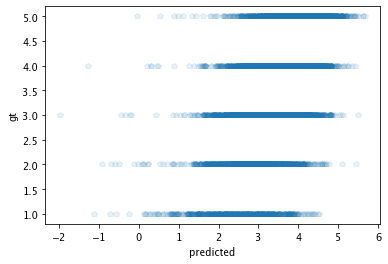

In [21]:
plt.plot(out["rate_preds_test"],test_sparse.data,"p",alpha=0.1)
plt.xlabel("predicted")
plt.ylabel("gt")
plt.show()